In [46]:
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBRFClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from yellowbrick.classifier import ConfusionMatrix, ROCAUC


# Import labeled data

In [116]:
labeled_df = pd.read_csv("../data/user_labeled/final_labeled.csv")
print(labeled_df.label.value_counts())
labeled_df

before    140
after     137
Name: label, dtype: int64


,node,label,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,Pitch contour,before,0.811917,0.008546,0.478604,0.333313,3.565994e-05,9.155767e-06,4.538325e-07,0.000058,0.008546,0.017093,1.885257e-05,0.008546,1.091970e-02
1,Contrapuntal motion,before,0.799874,0.018602,0.539450,0.260424,3.073561e-04,2.314712e-05,5.486180e-07,0.000022,0.018602,0.018602,2.397493e-04,0.000000,1.833478e-02
2,False relation,before,0.815793,0.008867,0.434498,0.381294,1.562247e-04,1.179012e-05,3.516609e-07,0.000053,0.008867,0.008867,1.260127e-04,0.000000,8.475446e-03
3,Consecutive fifths,before,0.788316,0.006569,0.210218,0.578099,1.626513e-04,1.016740e-05,1.852400e-07,0.000011,0.006569,0.006569,5.940591e-05,0.000000,6.170700e-03
4,Part (music),before,0.812984,0.000000,0.471821,0.341163,1.377333e-04,1.176928e-05,6.551787e-07,0.000037,0.003629,0.003629,9.060537e-05,0.003629,3.244365e-03
5,Common practice period,after,0.778737,0.000000,0.601881,0.176856,1.816769e-04,3.517272e-05,4.421708e-07,0.000021,0.002853,0.002853,1.713103e-04,0.002853,2.543915e-03
6,Monophony,before,0.788887,0.002988,0.576724,0.212163,5.457056e-05,5.152674e-06,4.896373e-07,0.000017,0.002988,0.002988,4.038120e-05,0.000000,2.538365e-03
7,The Well-Tempered Clavier,after,0.816198,0.001520,0.427098,0.389100,5.648655e-05,2.005541e-05,2.275949e-07,0.000037,0.001520,0.001520,3.927449e-05,0.000000,1.148115e-03
8,Post-tonal music theory,after,0.783535,0.000000,0.195884,0.587651,4.425679e-04,1.749719e-05,1.436792e-07,0.000042,0.043530,0.021765,1.498728e-04,0.000000,3.285244e-04
9,Atmosphères,after,0.800124,0.005406,0.259500,0.540624,8.510854e-05,4.176538e-06,8.031867e-08,0.000053,0.010812,0.005406,2.404556e-05,0.000000,3.432770e-03


# Exploration - PCA Plotting

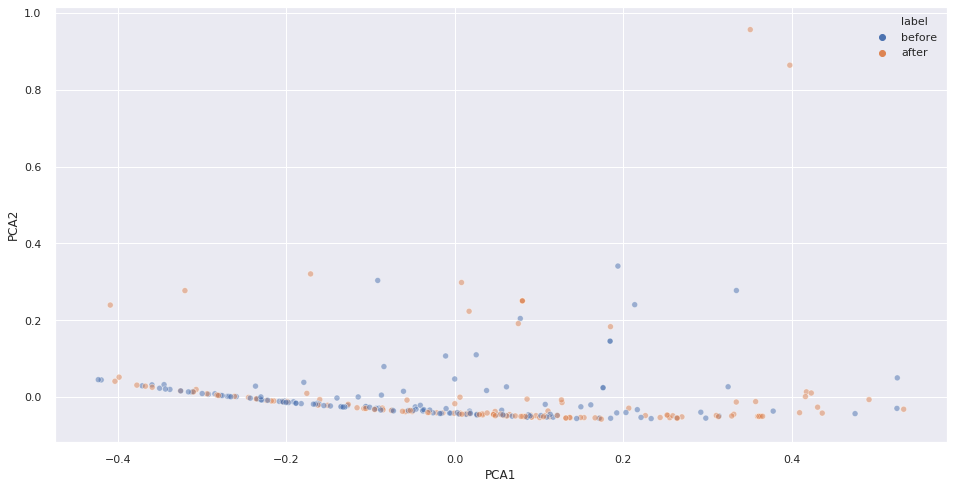

In [117]:
pca = PCA(n_components = 2, )

components_df = pd.DataFrame(pca.fit_transform(labeled_df.drop(["node", "label"], axis=1)),
                            columns=["PCA1", "PCA2"])

components_df['label'] = labeled_df['label']

# components_df = components_df[components_df.PCA1 > 0.2]

# components_df.label.value_counts()

plt.figure(figsize=(16,8))
sns.scatterplot(data=components_df, x="PCA1", y='PCA2', hue='label', alpha=0.5)

# Test Train Split

In [150]:
X = labeled_df.drop([
    "node", 
    "label", 
    "similarity_rank",
    
    # trimming less valuable estimators
#     "shortest_path_length_to_entry",
#     "primary_link",
#     "category_matches_with_source",
#     "shortest_path_length_from_entry",
#     "in_edges",
#     "adjusted_reciprocity",
    
], axis=1)
y = labeled_df.label

cols = X.columns 

# class imbalance
ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()

#################
# UNDERSAMPLING #
#################
# X, y = rus.fit_sample(X, y)

# X = pd.DataFrame(X, columns=cols)
# y = pd.Series(y)

#########
# SMOTE #
#########
# X, y = smote.fit_sample(X, y)
# X = pd.DataFrame(X, columns=cols)
# y = pd.Series(y)

# basic train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

################
# OVERSAMPLING #
################
# X_train, y_train = ros.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_train, columns=cols)
# y_train = pd.Series(y_train)

# X_test, y_test = ros.fit_sample(X_test, y_test)
# X_test = pd.DataFrame(X_test, columns=cols)
# y_test = pd.Series(y_test)

#############
# FULL DATA #
#############
# X_train = X
# y_train = y

print("Train Classes:")
print(y_train.value_counts(), "\n")
print("Test Classes:")
print(y_test.value_counts(), "\n")

Train Classes:
after     125
before    124
Name: label, dtype: int64 

Test Classes:
before    16
after     12
Name: label, dtype: int64 



# Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Best Params:	 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100} 


              precision    recall  f1-score   support

       after       0.79      0.92      0.85        12
      before       0.93      0.81      0.87        16

    accuracy                           0.86        28
   macro avg       0.86      0.86      0.86        28
weighted avg       0.87      0.86      0.86        28

Train Score:	 0.7028112449799196
Test Score:	 0.8571428571428571


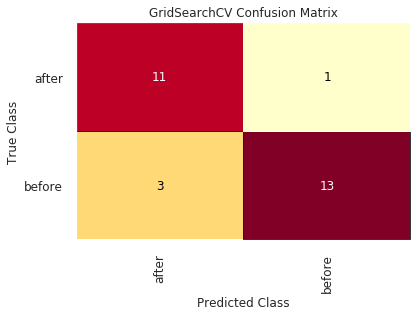

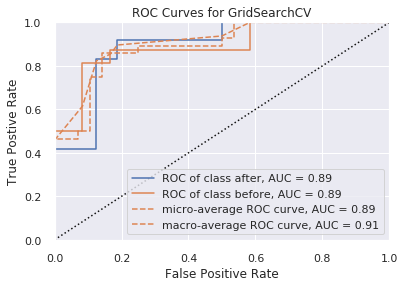

In [151]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# GridSearch params
params = {
#     "pca__n_components": [4,5,6,7,8,9],
    
    "criterion": ["entropy"], # entropy
    "n_estimators": [100], # 100
    "max_depth": [2], # 10
    "min_samples_split": [5], # 5
    "min_samples_leaf": [10], # 10
    "max_leaf_nodes": [8], # 8
    "bootstrap": [True]
    
}

rf_model = GridSearchCV(rf, params, n_jobs=-1, cv=3, verbose=2)

rf_model.fit(X_train, y_train)

y_preds = rf_model.predict(X_test)

cm = ConfusionMatrix(rf_model, classes=rf_model.classes_, is_fitted=True)
visualizer = ROCAUC(rf_model, classes=rf_model.classes_, is_fitted=True)

print("Best Params:\t", rf_model.best_params_, "\n\n")
print(classification_report(y_test, y_preds, target_names=rf_model.classes_))
print("Train Score:\t", rf_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))

cm.poof()

visualizer.score(X_test, y_test)
visualizer.poof()

In [152]:

best_estimators = pd.DataFrame(list(zip(X_train.columns, rf_model.best_estimator_.feature_importances_)), 
             columns=["Feature", "Estimation Strength"])

best_estimators.sort_values("Estimation Strength", ascending=False)

,Feature,Estimation Strength
2,in_edges,0.150232
1,category_matches_with_source,0.143857
0,degree,0.099826
3,out_edges,0.098225
4,shared_neighbors_with_entry_score,0.094709
10,jaccard_similarity,0.086954
7,adjusted_reciprocity,0.078821
8,shortest_path_length_from_entry,0.066178
5,centrality,0.058920
6,page_rank,0.055792


Saving model with pickle

In [153]:
with open("../models/rf_classifier_v2.pkl", "wb") as model:
    pickle.dump(rf_model.best_estimator_, model,)

# XG Boost

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Train Score:	 0.7737556561085973
Test Score:	 0.6071428571428571


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


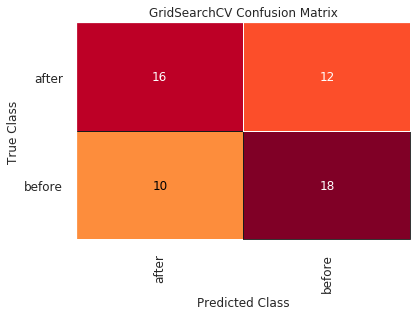

Best Params:	 {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [103]:
model = XGBRFClassifier(random_state=10, )

params = { 
    "max_depth": [3],
    "n_estimators": [100, 200],
    "learning_rate": [0.01],
    "gamma": [0.001]
}

xg_model = GridSearchCV(model, params, n_jobs=-1, cv=3, verbose=2)

xg_model.fit(X_train, y_train)

cm = ConfusionMatrix(xg_model, classes=["after", "before"], is_fitted=True)

print("Train Score:\t", xg_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()
print("Best Params:\t", xg_model.best_params_)

# SVM

In [104]:
pca = PCA()
model = SVC()

steps = [
    ("pca", pca),
    ("svm", model)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 15],
    "svm__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__decision_function_shape": ['ovo', 'ovr'],
    "svm__shrinking": [True, False]
}

svc_model = GridSearchCV(pipe, params, n_jobs=-1, cv=10, verbose=2)

cm = ConfusionMatrix(svc_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

# KNN

Fitting 3 folds for each of 176 candidates, totalling 528 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 528 out of 528 | elapsed:    6.9s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5535714285714286


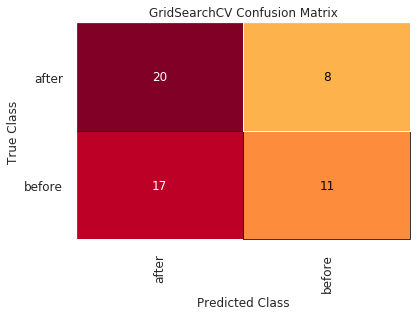

In [105]:
pca = PCA()
knn = KNeighborsClassifier(n_jobs=-1,)

steps = [
    ("pca", pca),
    ("knn", knn)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "knn__n_neighbors": [k for k in range(5, 26) if k % 2 != 0],
    "knn__metric": ['minkowski', "euclidean", "chebyshev", "wminkowski"]
}

knn_model = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=2, scoring="accuracy", error_score=0.0)

cm = ConfusionMatrix(knn_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

Best Params:	 {'priors': [0.5, 0.5]} 


Train Score:	 0.5565610859728507
Test Score:	 0.5892857142857143


/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


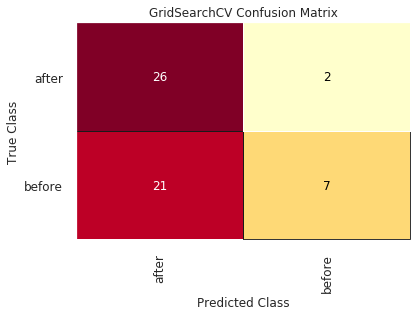

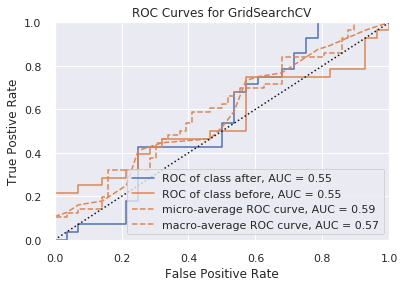

In [106]:
nb = GaussianNB()

params = {
    "priors": [[0.5, 0.5]],
}

nb_model = GridSearchCV(nb, param_grid=params, cv=3)

nb_model.fit(X_train, y_train)

cm = ConfusionMatrix(nb_model, classes=["after", "before"], is_fitted=True)
visualizer = ROCAUC(nb_model, classes=["after", "before"], is_fitted=True)


print("Best Params:\t", nb_model.best_params_, "\n\n")
print("Train Score:\t", nb_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()


visualizer.score(X_test, y_test)
visualizer.poof()